<a href="https://colab.research.google.com/github/OvejaVerde/colab/blob/main/V2TRPM8_ChemBL_LSTMChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio Diseño de Novo - Ligand-Based | Matías Zúñiga**

*   Curso: Biomedicina y Biofarmaceutica
*   Profesor: Horacio Poblete
*   Ayudante: Eduardo Cubillos

---

Laboratorio de diseño de moleculas (*de novo*) utilizando herramientas de machine learning. Este cuaderno está basado en los códigos implementados por Chanin Nantasenamat (https://github.com/dataprofessor/code/tree/master/python) y la implementación de LSTM-Chem disponible en https://github.com/topazape/LSTM_Chem 

# En este laboratorio utilizaremos compuestos conocidos que se asocian a TRPM8 y entrenaremos un modelo de machine learning tipo LSTM en forma fine tuning. 

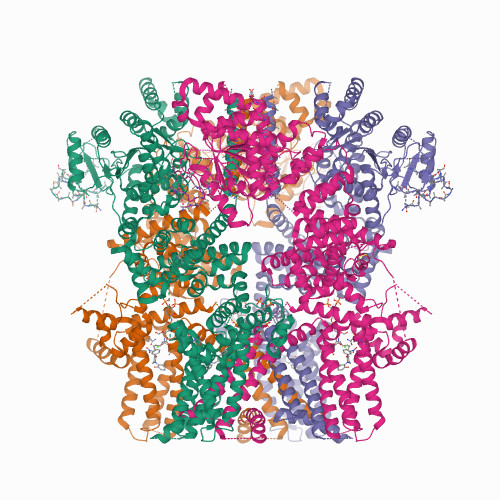

ESTRUCTURA DE LA PROTEINA Transient receptor potential cation channel subfamily M member 8

## **ChEMBL Database**

La base de datos [*ChEMBL*](https://www.ebi.ac.uk/chembl/) contiene millones de compuestos con actividad biológica. A través de esta se pueden obtener los códigos, SMILES y diferentes propiedades de interés para cada compuesto. 

## **Instalación de librerías**

En este practico instalaremos los paquetes necesarios para hacer consultas a la base de dato de compuestos de CheMBL.

In [1]:
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importación de Librerías**

In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

## **Búsqueda de Compuestos en una Proteína Target**

### **Búsqueda del Target TRPM8 Humano**

In [ ]:
# Target search for TRPM8
target = new_client.target
target_query = target.search('Transient receptor potential cation channel subfamily M member 8')
targets = pd.DataFrame.from_dict(target_query)
targets

### **Seleccionar y obtener valores de actividad para nuestra proteina target**

Asignaremos el tercer valor correspondiente a nuestro target TRPM8 Humano

In [ ]:
selected_target = targets.target_chembl_id[1]
selected_target

Acá obtendremos aquellos compuestos que presentan ensayos de actividad de tipo IC50. Revisar documentación de CheMBL para incluir otro tipo de filtros.

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
df = pd.DataFrame.from_dict(res)

In [ ]:
df

Guardaremos esta informacion en un primer archivo de tipo CSV  **bioactivity_data.csv**.

In [ ]:
df.to_csv('TRPM8_01_bioactivity_data_raw.csv', index=False)

## **Manejando datos faltantes o erróneos**
Si algún compuesto no incluye valores en las columnas **standard_value** o **canonical_smiles** se eliminará.

In [ ]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

In [ ]:
len(df2.canonical_smiles.unique())

In [ ]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

## **Procesamiento de datos de Bioactividad**

### **Se combinará la información de las columnas canonical_smiles, molecule_chembl_id y standard_value y se generará una nueva columna de tipo class**

In [ ]:
selection = ['canonical_smiles', 'molecule_chembl_id','standard_value']
df3 = df2_nr[selection]
df3

Guardaremos el progreso en un archivo CSV

In [ ]:
df3.to_csv('TRPM8_02_bioactivity_data_preprocessed.csv', index=False)

### **Clasificación de Compuestos Activos, Intermedios y No activos**
La información de actividad biológica está en unidades de IC50. Los compuestos que tienen valores menores a 100 nM se considerarán como **activo** mientras que valores superiores a 10000 nM se definirán como **no activo**. En el rango 1000-10000 se definirán con actividad **intermedia**. 

In [ ]:
df4 = pd.read_csv('TRPM8_02_bioactivity_data_preprocessed.csv')

In [ ]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

In [ ]:
selection = ['canonical_smiles', 'molecule_chembl_id','class']
df6 = df5[selection]
df6 = df6[df6['class'] != "inactive"]
df6

Guardaremos la informacion en un archivo CSV

In [ ]:
df6.to_csv('TRPM8_03_bioactivity_data_curated.csv', index=False, sep = '\t')

Finalmente, solo guardaremos aquellos compuestos que tienen actividad biológica por nuestro target (formato SMI)

In [ ]:
df7 = df6['canonical_smiles']
df7



In [ ]:
df7.to_csv('TRPM8_inhibitors.smi', index=False, header=None, sep = '\t')

# **Ahora utilizaremos LSTM_Chem para generar nuevos compuestos**

In [ ]:
!git clone https://github.com/topazape/LSTM_Chem

In [ ]:
cd LSTM_Chem/

In [ ]:
!pip install -r requirements.txt

---

Reinstalaremos matplotlib para poder visualizar un grafico posterior

In [ ]:
!pip --no-input uninstall matplotlib
!pip install matplotlib==3.1.3

Importamos las librerias necesarias para realizar el practico

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

Se crea un modelo para finetuning utilizando como set de datos 5 moleculas conocidas y se entrena por 12 epocas. Para sistemas propios revisar archivos config.json y base.json

In [ ]:
config = process_config('experiments/2020-03-24/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Se crean 100 moleculas nuevas 

In [ ]:
finetuned_smiles = finetuner.sample(num=100)

Utilizaremos este archivo para comparar los componentes principales

In [ ]:
!python cleanup_smiles.py -ft ../TRPM8_inhibitors.smi ./TRPM8-inhibitors_cleaned.smi

In [ ]:
with open('./TRPM8-inhibitors_cleaned.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

Cargamos las moleculas utilizadas para el FINETUNING

In [ ]:
with open('./datasets/TRPM8_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

Cargamos las moleculas generadas por el modelo.

In [ ]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

Calculamos los 2 componentes principales de los grupos de moleculas con el fin de compararlas.

In [ ]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

Graficamos los 2 PCA del set de moleculas conocidas, las 5 para finetuning y las generadas.

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 new molecules')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

Seleccionamos aquellas que tengan un mejor indicide de Tanimoto (se parezcan mas)

In [ ]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

Las agregamos a un arreglo para compararlas con las 5 seleccionadas del finetuning

In [ ]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

Observaremos a la izquierda la molecula original tomada para el finetuning y a la derecha la molecula mas parecida generada por el modelo.

In [ ]:
Draw.MolsToGridImage(showmols, molsPerRow=2)


Finalmente obtenemos los SMILES de las moleculas generadas

In [ ]:
for molecule in nsmols:
    mol = Chem.MolToSmiles(molecule)
    print(mol)